
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# your code here
X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index = X_train.index)
X_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns = X_test.columns, index = X_test.index)
X_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,0.621681,0.321146,...,0.477952,0.622254,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,0.674740,0.341671,...,0.435211,0.519185,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,0.289416,0.329466,...,0.410134,0.253019,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,0.395238,0.394697,...,0.474741,0.450396,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,0.505418,0.301920,...,0.263812,0.532818,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


In [5]:
print(X_train.shape)

(601, 7129)


**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [6]:
# your code here
# your code here
multiReg = LogisticRegression(C = 1000000, solver = 'lbfgs').fit(X_train, y_train)
multiRegPredictTrain = multiReg.predict_proba(X_train)[:, 1]
multiRegPredictTest = multiReg.predict_proba(X_test)[:, 1]

for i in range(len(multiRegPredictTrain)):
    if multiRegPredictTrain[i] > .5:
        multiRegPredictTrain[i] = 1
    else:
        multiRegPredictTrain[i] = 0
        
for i in range(len(multiRegPredictTest)):
    if multiRegPredictTest[i] > .5:
        multiRegPredictTest[i] = 1
    else:
        multiRegPredictTest[i] = 0
        
print("The misclassification rate of the logistic model on the training set is {}.".format(1-accuracy_score(multiRegPredictTrain, y_train)))
print("The misclassification rate of the logistic model on the test set is {}.".format(1-accuracy_score(multiRegPredictTest, y_test)))

The misclassification rate of the logistic model on the training set is 0.0.
The misclassification rate of the logistic model on the test set is 0.2715231788079471.


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [7]:
# your code here
# your code here
crossValidPavlos = LogisticRegressionCV(cv = 10, solver = 'liblinear', penalty = 'l1').fit(X_train, y_train)

predictionCV = crossValidPavlos.predict_proba(X_train)[:, 1]
for i in range(len(predictionCV)):
    if predictionCV[i] > .5:
        predictionCV[i] = 1
    else:
        predictionCV[i] = 0
        
CVAccuracyTrain = accuracy_score(predictionCV, y_train)
print("Misclassification rate using cross validation on the training set: {}".format(1-CVAccuracyTrain))

predictionCVTest = crossValidPavlos.predict_proba(X_test)[:, 1]
for i in range(len(predictionCVTest)):
    if predictionCVTest[i] > .5:
        predictionCVTest[i] = 1
    else:
        predictionCVTest[i] = 0
CVAccuracyTest = accuracy_score(predictionCVTest, y_test)
print("Misclassification rate using cross validation on the test set: {}".format(1-CVAccuracyTest))

Misclassification rate using cross validation on the training set: 0.08985024958402665
Misclassification rate using cross validation on the test set: 0.17880794701986757


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [8]:
# your code here
k_list = [1, 2, 3, 4, 5, 7, 9, 10, 15, 25]
best_k = 0
best_model = None
best_score = -1

for k in k_list:
    model = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(model, X_train, y_train, cv = 5)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_k = k
knn = best_model.fit(X_train, y_train)

best_test_score = np.mean(knn.score(X_test, y_test))
print("The best k for our classification model will be {}".format(best_k))
print("The k = {} model has a misclassification rate on the training set of {}".format(best_k, 1-best_score))
print("The k = {} model has a misclassification rate on the test set of {}".format(best_k, 1-best_test_score))

The best k for our classification model will be 7
The k = 7 model has a misclassification rate on the training set of 0.12482811306340713
The k = 7 model has a misclassification rate on the test set of 0.13907284768211925


In [9]:
knnPredictTest = knn.predict(X_test)

**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [10]:
# your code here
regressConf = confusion_matrix(y_test, multiRegPredictTest)
CVConf = confusion_matrix(y_test, predictionCVTest)
knnConf = confusion_matrix(y_test, knnPredictTest)

print("Confusion Matrix for Multiple Regression Predictions")
print(regressConf)
print("False positive rates for multiple regression predictions: {}".format(regressConf[0][1]/np.sum(regressConf[0])))
print("False negative rates for multiple regression predictions: {}".format(regressConf[1][0]/np.sum(regressConf[1])))
print("")
print("Confusion Matrix for LASSO-Regularized with Cross-Validation Model Predictions")
print(CVConf)
print("False positive rates for LASSO-regularized with Cross-Validation predictions: {}".format(CVConf[0][1]/np.sum(CVConf[0])))
print("False negative rates for LASSO-regularized with Cross-Validation predictions: {}".format(CVConf[1][0]/np.sum(CVConf[1])))
print("")
print("Confusion Matrix for k-NN Classification with Cross Validation Model Predictions")
print(knnConf)
print("False positive rates for k-NN classification with Cross-Validation predictions: {}".format(knnConf[0][1]/np.sum(knnConf[0])))
print("False negative rates for k-NN classification with Cross-Validation predictions: {}".format(knnConf[1][0]/np.sum(knnConf[1])))

Confusion Matrix for Multiple Regression Predictions
[[66 11]
 [30 44]]
False positive rates for multiple regression predictions: 0.14285714285714285
False negative rates for multiple regression predictions: 0.40540540540540543

Confusion Matrix for LASSO-Regularized with Cross-Validation Model Predictions
[[67 10]
 [17 57]]
False positive rates for LASSO-regularized with Cross-Validation predictions: 0.12987012987012986
False negative rates for LASSO-regularized with Cross-Validation predictions: 0.22972972972972974

Confusion Matrix for k-NN Classification with Cross Validation Model Predictions
[[67 10]
 [11 63]]
False positive rates for k-NN classification with Cross-Validation predictions: 0.12987012987012986
False negative rates for k-NN classification with Cross-Validation predictions: 0.14864864864864866


I notice that the false positive rates are quite similar between all three models, ranging from ..1298 to .1429, whereas the false negative rates have a great deal of variability. The multiple regression model had the highest false negative rate with .4054, followed by the LASSO-regularized model with a much lower yet still significant false negative rate of .2297, and finally the k-NN model with a still significant but much lower false positive rate of .1486. None of these results are particularly promising. Especially with a disease like cancer, being diagnosed as negative or safe from the disease when you are in fact actually positive can have devastating consequences for one's life and possibility of pursuing early and effective treatment.

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [11]:
# adapted from lab 8
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(X_train)
x_train_scaled = scale_transformer.transform(X_train)
x_test_scaled = scale_transformer.transform(X_test)

# reduce dimensions
pca_transformer = PCA().fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

In [12]:
print("Shape of the X_train PCA decomposition: {}".format(x_train_2d.shape))
x_train_2d[0:5,:]

Shape of the X_train PCA decomposition: (601, 601)


array([[-3.97372718e+00, -2.52047603e+00, -1.58440100e+00, ...,
        -1.82405735e-01,  1.31145095e-15,  3.31679129e-15],
       [-1.28463907e+01, -1.37308477e+01, -8.35328678e+00, ...,
        -4.91742712e-02,  1.38083989e-15, -2.06085149e-15],
       [-1.45286816e+01, -1.66879305e+01, -1.24884524e+01, ...,
         2.60450294e-01, -7.59808882e-16, -1.42941214e-15],
       [ 6.94658493e+00, -1.54691883e+01,  1.77622208e+01, ...,
        -1.72701285e+00, -2.12677098e-15, -4.85722573e-16],
       [ 8.93352794e-01, -1.43119937e+01, -3.31111548e+00, ...,
         2.98917901e-01,  2.21524188e-15,  3.77475828e-15]])

In [13]:
print("Shape of the X_test PCA decomposition: {}".format(x_test_2d.shape))
x_test_2d[0:5,:]

Shape of the X_test PCA decomposition: (151, 601)


array([[-12.7145646 ,  22.05101488,   2.92789943, ...,   0.10332169,
         -2.04734803,  -1.11970135],
       [ 31.55431537,  42.49597094,  15.39938613, ...,   0.36907037,
         -0.79267825,  -0.71887437],
       [ 32.97070572,  46.1497752 ,  18.39844398, ...,  -0.98436417,
         -1.66731088,  -0.48889438],
       [-30.18870813,   4.4626043 ,  -6.51128415, ...,   0.04707187,
         -1.62756842,   0.49185329],
       [-20.89739986,  -4.47720641,  -3.70309035, ...,  -0.53777632,
         -0.11496058,  -1.09556669]])

The limiting factor for the maximum amount of PCA components for this data set is the amount of observations, in this case 601, that we have in the training set. Since the PCA is based on the training set, and the number of observations is less than the amount of predictors, we know that the limiting factor is the amount of observations. In order to ensure the necessary linear independence of each component in PCA as explained in Lab 8, we cannot have more components than the amount of observations. For us, this means we cannot have more than 601 PCA components for this data set.

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

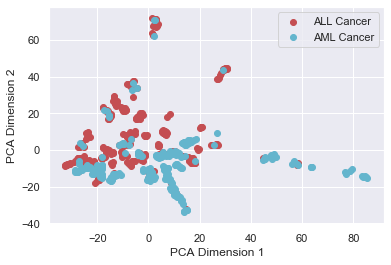

In [14]:
# adapted from lab 8
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c']
label_text = ["ALL Cancer", "AML Cancer"]

# and we loop over the different groups
for cur_quality in [0,1]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend();

Using the scatterplot of the top 2 PCA vectors is a useful approach to visualizing a high dimensional classification problem because it makes the whole dataset easier to visualize, especially with respect to how separable the data points are with respect to what classes they belong to. Using the scatterplot with the top 2 PCA vectors uses all of the variables in unique linear combinations to form two dimensions. It would be impossible to visualize this data along the thousands of predictors we have, but this approach allows us to visualize the data along only two axes, with both of those dimensions accounting for a significant amount of the variability in the data.

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

In [15]:
# adapted from lab 8
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by top PCA component:", var_explained[0])
print("Variance explained by second top PCA component:", var_explained[1])
print("Total Variance Explained by Top 2 PCA Vectors:", var_explained[0] + var_explained[1])

Variance explained by top PCA component: 0.06281545883254593
Variance explained by second top PCA component: 0.049381328895098726
Total Variance Explained by Top 2 PCA Vectors: 0.11219678772764466


The first PCA dimension captures 6.28% of the variance in the data, and the second PCA dimension captures 4.94%.

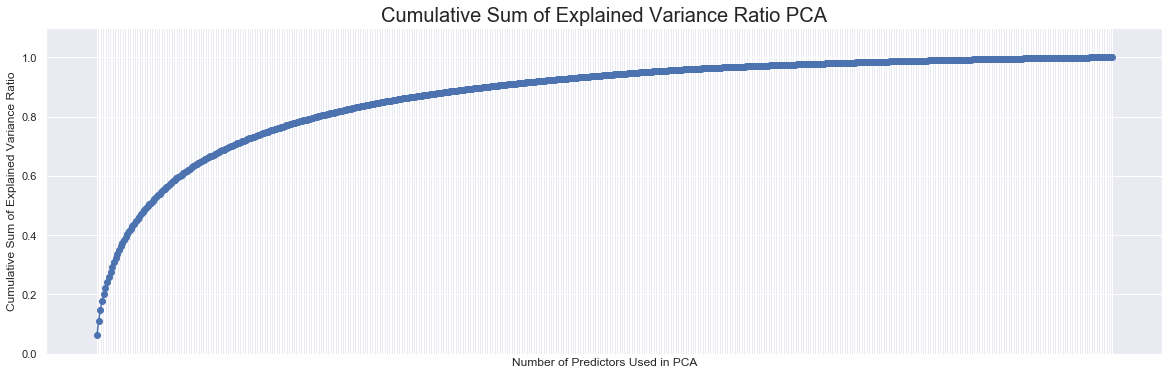

In [16]:
# fitting the PCA object onto our dataframe (excluding the model name column)
pca = PCA().fit(x_train_scaled)
fig, ax = plt.subplots(ncols=1, figsize=(20,6))

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax.plot(np.cumsum(ratio), 'o-')

ax.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax.set_ylim(0,1.1)
ax.set_xticks(range(len(ratio)))
ax.set_xlabel('Number of Predictors Used in PCA')
ax.set_xticklabels(['{}'.format(i+1) for i in range(len(ratio))])
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::50]:
    label.set_visible(True)
ax.set_ylabel('Cumulative Sum of Explained Variance Ratio');

In [17]:
for i, value in enumerate(np.cumsum(ratio)):
    if value > .9:
        number = i
        break
print("At least {} vectors are needed to explain at least 90% of the variability of the predictors. \nHaving {} vectors in your PCA explains, as a proportion, {} of variability ".format(number, number, np.cumsum(ratio)[number]))

At least 231 vectors are needed to explain at least 90% of the variability of the predictors. 
Having 231 vectors in your PCA explains, as a proportion, 0.9006619693174368 of variability 


**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

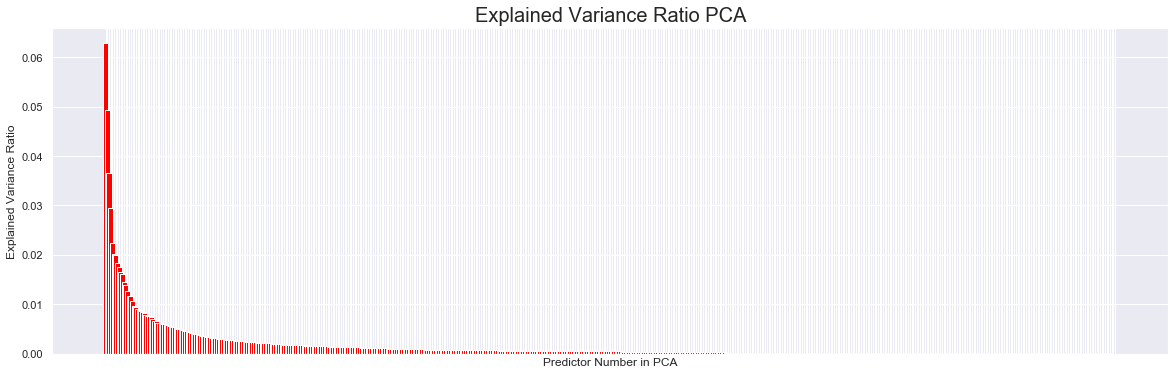

In [18]:
#your code here
fig, ax = plt.subplots(ncols=1, figsize=(20,6))

ratio = pca.explained_variance_ratio_
ax.bar(range(len(ratio)), ratio, color='red', width = 3)
ax.set_title('Explained Variance Ratio PCA', fontsize=20)
ax.set_xticks(range(len(ratio)))
ax.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax.set_xlabel('Predictor Number in PCA')
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels()[::50]:
    label.set_visible(True)
ax.set_ylabel('Explained Variance Ratio');

In [19]:
print("Explained variance ratio with 100 components: {}".format(np.cumsum(ratio)[100]))

Explained variance ratio with 100 components: 0.7476102063663522


From eyeballing the plot from 2.3, "Cumulative Sum of Explained Variance Ratio PCA", we would argue that having 100 components strikes a balance between parsimony, or not having an unnecessarily large amount of predictors, while still having enough to be representative of the data by capturing, as shown directly above, about 75% of the variance in the dataset.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [20]:
modelNames = ["PCA with Just First Two Vectors", "PCA with Chosen Number of Vectors (100)", "PCA with 90% of Variability Explained", "Question 1: MLR", "Question 1: Regularized MLR", "Question 1: K-NN"]
num_components = [2, 100, 231]
scores = []
for num in num_components:
    model = PCA(num).fit(x_train_scaled)
    x_train_2dModel = model.transform(x_train_scaled) 
    x_test_2dModel = model.transform(x_test_scaled) 
    lr = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2dModel,y_train)
    lr_pca_train_accuracy = lr.score(x_train_2dModel, y_train)
    lr_pca_test_accuracy = lr.score(x_test_2dModel, y_test)
    scores.append([lr_pca_train_accuracy, lr_pca_test_accuracy])
scores.append([accuracy_score(multiRegPredictTrain, y_train), accuracy_score(multiRegPredictTest, y_test)])
scores.append([CVAccuracyTrain, CVAccuracyTest])
scores.append([best_score, best_test_score])
df_results = pd.DataFrame(scores, index = modelNames, columns = ['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
PCA with Just First Two Vectors,0.758735,0.801325
PCA with Chosen Number of Vectors (100),0.921797,0.741722
PCA with 90% of Variability Explained,1.000000,0.662252
Question 1: MLR,1.000000,0.728477
Question 1: Regularized MLR,0.910150,0.821192
Question 1: K-NN,0.875172,0.860927


The classification accuracy values on the training sets for the PCA model with the first two vectors is worse than any of the training accuracies for the models fit in question 1. On the other hand, with 100 vectors, the accuracy is better than the regularized MLR and k-NN where k = 7. As for test accuracy, the PCA with 100 vectors and 2 vectors seem to be more accurate than the MLR in Question 1 and comparable with the values of the regularized MLR and the k-NN model from question 1. Yet, the PCA with 90% of variability explained, or 231 vectors, is significantly lower than any of the values we received from question 1, perhaps because using 231 vectors overfits the model, leading our accuracy in the test set to suffer.

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [21]:
num_components = [2, 100, 231]
scoresCV = []
for num in num_components:
    model = PCA(num).fit(x_train_scaled)
    x_train_2dModel = model.transform(x_train_scaled) 
    x_test_2dModel = model.transform(x_test_scaled) 
    lr = LogisticRegressionCV(cv = 10, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2dModel,y_train)
    lr_pca_train_accuracy = lr.score(x_train_2dModel, y_train)
    lr_pca_test_accuracy = lr.score(x_test_2dModel, y_test)
    scoresCV.append([lr_pca_train_accuracy, lr_pca_test_accuracy])
df_resultsCV = pd.DataFrame(scoresCV, index = num_components, columns = ['Train Accuracy', 'Test Accuracy'])
df_resultsCV

,Train Accuracy,Test Accuracy
2,0.763727,0.794702
100,0.901830,0.867550
231,0.903494,0.867550


In [22]:
bestCV = PCA(231).fit(x_train_scaled)
x_train_2dModel = bestCV.transform(x_train_scaled) 
x_test_2dModel = bestCV.transform(x_test_scaled) 
bestCVLR = LogisticRegressionCV(cv = 10, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2dModel,y_train)

In [23]:
geneLoc = X_train.columns.get_loc('M31523_at')
coefficients = np.dot(bestCVLR.coef_, bestCV.components_)[0]
print("The relationship between Cancer_type vs. M31523_at can be characterized by a slope of {}".format(coefficients[geneLoc]))
print("For every one unit increase in the value of M31523_at, there is a predicted, corresponding change of {} in the prediction value for Cancer type".format(coefficients[geneLoc]))

The relationship between Cancer_type vs. M31523_at can be characterized by a slope of -0.003668102440317017
For every one unit increase in the value of M31523_at, there is a predicted, corresponding change of -0.003668102440317017 in the prediction value for Cancer type


**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

The AUC and ROC seek to minimize false positives. The ROC curve shows you the false positive or false negative rate on the x-axis and the true positive or true negative on the y-axis. The ideal curve hugs the top left corner because it has a high true positive rate and a low false positive rate. The more that it stays close to the top left corner, the higher the area under the ROC curve (AUC) will be, which means that we are optimizing by having as high of a true positive rate as possible while also having as low of a false positive rate as possible. This approach differs from evaluating models solely based on misclassification rate because it accounts for false positive rates and true positive rates on the same scale. In scenarios where one group has a significant majority (example- cancer classification), the misclassification rate tells you much less than the AUC approach. Imagine a disease for which 99% of people are actually negative. If a test instrument were to classify everyone as negative, it would have a 99% accuracy rate, but that's not important, because 100% of the people who actually have the disease will be misclassified. The AUC approach, on the other hand, would show that there is a significant problem with the model as the false negative rate would be extremely high and the AUC would decrease significantly, identifying this startling problem with the model.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [24]:
# your code here
AUCScores = []
tests = ['Multiple Linear Regression', 'Cross Validation Regularized with LASSO', 'k-NN Prediction', 'PCA with 2 Components', 'PCA with 100 Components', 'PCA with 231 Components']
AUCScores.append(roc_auc_score(y_test, multiRegPredictTest))
AUCScores.append(roc_auc_score(y_test, predictionCVTest))
AUCScores.append(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))
for n in [2, 100, 231]:
    nModel = PCA(n).fit(x_train_scaled)
    x_train_2dMod = nModel.transform(x_train_scaled) 
    x_test_2dMod = nModel.transform(x_test_scaled) 
    lrn2 = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2dMod,y_train)
    AUCScores.append(roc_auc_score(y_test, lrn2.predict_proba(x_test_2dMod)[:, 1]))

In [25]:
AUCScoresDf = pd.DataFrame(AUCScores, index = tests, columns = ['AUC Score'])
AUCScoresDf

,AUC Score
Multiple Linear Regression,0.725869
Cross Validation Regularized with LASSO,0.820200
k-NN Prediction,0.864251
PCA with 2 Components,0.821867
PCA with 100 Components,0.865391
PCA with 231 Components,0.784837


Evidently, the highest AUC on the test set comes from the k-NN prediction model used in question 1, with an AUC of .86421.

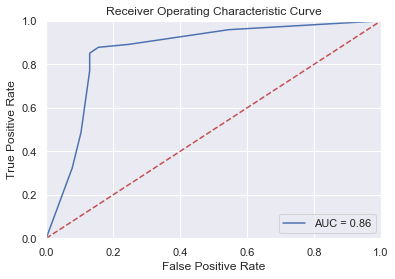

In [26]:
# adapted from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
preds = knn.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The plot shows a strong AUC score of approximately .86, as most of the area of the graph falls under the ROC curve. The curve hugs the top left corner of the graph, which suggests that there are few false positives despite having mostly true positive rates for this model.

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

Based on AUC, the k-NN prediction, regularized cross-validation with LASSO, PCA with 2 components, and PCA with 100 components all hover between .82 and .86 for their AUC score. This suggests that many models are similar in prediction, even though the k-NN prediction has the highest value. For predicting real cancer patients, I would use the kNN prediction by finding the "nearest neighbors" to the current patient in terms of genetic values and averaging their cancer type score (0 or 1) to make a prediction value for the given patient. For the other types of models, I would use the patient's genetic values as parameters and see the prediction score ultimately turned out by the models, ultimately classifying them into a predicted type.

<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [27]:
compas_df = pd.read_csv('data/compas.csv')
compas_df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,69,F,Aggravated Assault w/Firearm,Other,Low,Male,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
1,34,F,Felony Battery w/Prior Convict,African-American,Low,Male,0,0,0,0,3,1,10,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,Male,4,0,0,1,4,1,1,0,1,0,0,0,1,1,0,0,1
3,44,M,Battery,Other,Low,Male,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,Male,14,0,0,0,6,1,6,0,0,1,0,0,0,0,0,1,6


In [28]:
compas_df.shape

(6172, 23)

In [29]:
# since the question concerns a comparison of African-Americans and Caucasians, we will drop rows for those of other races
compas_df = compas_df[compas_df['race'].isin(['Caucasian', 'African-American'])]
compas_df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
1,34,F,Felony Battery w/Prior Convict,African-American,Low,Male,0,0,0,0,3,1,10,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,Male,4,0,0,1,4,1,1,0,1,0,0,0,1,1,0,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,Male,14,0,0,0,6,1,6,0,0,1,0,0,0,0,0,1,6
6,39,M,Battery,Caucasian,Low,Female,0,0,0,0,1,0,3,0,0,0,0,0,0,0,1,0,3
7,27,F,"Poss 3,4 MDMA (Ecstasy)",Caucasian,Low,Male,0,0,0,0,4,0,1,0,0,0,0,0,0,1,0,0,1


In [30]:
# drops the description column because there are too many values to be meaningfully one-hot-encoded
compas_df = compas_df.drop(columns = 'c_charge_desc')
compas_df = pd.get_dummies(compas_df, columns = ['c_charge_degree', 'score_text', 'sex', 'race'], drop_first = True)
compas_df.head()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_M,score_text_Low,score_text_Medium,sex_Male,race_Caucasian
1,34,0,0,0,0,3,1,10,0,0,0,0,0,0,0,1,0,10,0,1,0,1,0
2,24,4,0,0,1,4,1,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0
4,41,14,0,0,0,6,1,6,0,0,1,0,0,0,0,0,1,6,0,0,1,1,1
6,39,0,0,0,0,1,0,3,0,0,0,0,0,0,0,1,0,3,1,1,0,0,1
7,27,0,0,0,0,4,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1


In [31]:
X_train, X_test, y_train, y_test =train_test_split(compas_df.loc[:, compas_df.columns != 'two_year_recid'], 
                                                         compas_df.two_year_recid, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = compas_df.race_Caucasian)
X_train.head()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_M,score_text_Low,score_text_Medium,sex_Male,race_Caucasian
3767,37,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
6090,24,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
6072,38,16,2,3,0,9,33,0,0,1,1,1,0,0,1,0,30,1,0,0,1,0
3003,37,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1
5138,22,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0


In [32]:
# since we one-hot encoded race after dropping all but Caucasian and African-American, a 1 will be Caucasian and a 0 will be African-American
y_train.head()

3767    0
6090    0
6072    1
3003    0
5138    0
Name: two_year_recid, dtype: int64

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4222, 22), (4222,), (1056, 22), (1056,))

**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [34]:
# your code here
X_train.describe()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_M,score_text_Low,score_text_Medium,sex_Male,race_Caucasian
count,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000,4222.000000
mean,34.483657,3.448366,0.060872,0.099716,0.120085,4.621743,15.420654,0.179536,0.246566,0.257224,0.035291,0.061819,0.081004,0.191615,0.294647,0.146376,6.707011,0.348650,0.521554,0.276883,0.805779,0.398389
std,11.801489,4.894922,0.421906,0.521288,0.485301,2.845085,47.580067,0.383846,0.431063,0.437156,0.184537,0.240855,0.272874,0.393619,0.455938,0.353525,10.281475,0.476599,0.499594,0.447511,0.395646,0.489624
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,31.000000,2.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,42.000000,5.000000,0.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,80.000000,38.000000,10.000000,13.000000,7.000000,10.000000,800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
t_scores = []
AfrAm = compas_df[compas_df['race_Caucasian'] == 0]
N1 = len(AfrAm)
Cauc = compas_df[compas_df['race_Caucasian'] == 1]
N2 = len(Cauc)
for predictor in X_train.copy().drop(columns = 'race_Caucasian').columns:
    XBar1 = np.mean(AfrAm[predictor])
    XBar2 = np.mean(Cauc[predictor])
    Std1 = np.std(AfrAm[predictor])
    Std2 = np.std(Cauc[predictor])
    t_score = (np.abs(XBar1-XBar2))/np.sqrt((Std1**2/N1)+(Std2**2/N2))
    t_scores.append({'predictor': predictor, 't_score': t_score, 'AAMean': XBar1, 'CaucMean': XBar2})
#print(t_scores)

sortedTScores = sorted(t_scores, key=lambda k: k['t_score'], reverse = True)
print('Top 3 predictors that Discriminate Between the Two Races Based on T-Scores\n')
for i, score in enumerate(sortedTScores[:3], 1):
    print("{}. {} with a t test score of {}".format(i, score['predictor'], score['t_score']))
    print("The average value of {} for African-American individuals is {}".format(score['predictor'], score['AAMean']))
    print("The average value of {} for Caucasian individuals is {}".format(score['predictor'], score['CaucMean']))
    print("")

Top 3 predictors that Discriminate Between the Two Races Based on T-Scores

1. decile_score with a t test score of 21.85886488054081
The average value of decile_score for African-American individuals is 5.276850393700787
The average value of decile_score for Caucasian individuals is 3.635282929148835

2. score_text_Low with a t test score of 18.158205396354038
The average value of score_text_Low for African-American individuals is 0.4239370078740157
The average value of score_text_Low for Caucasian individuals is 0.6690442225392297

3. priors_count with a t test score of 15.717842123018121
The average value of priors_count for African-American individuals is 4.238110236220472
The average value of priors_count for Caucasian individuals is 2.2891107941036615



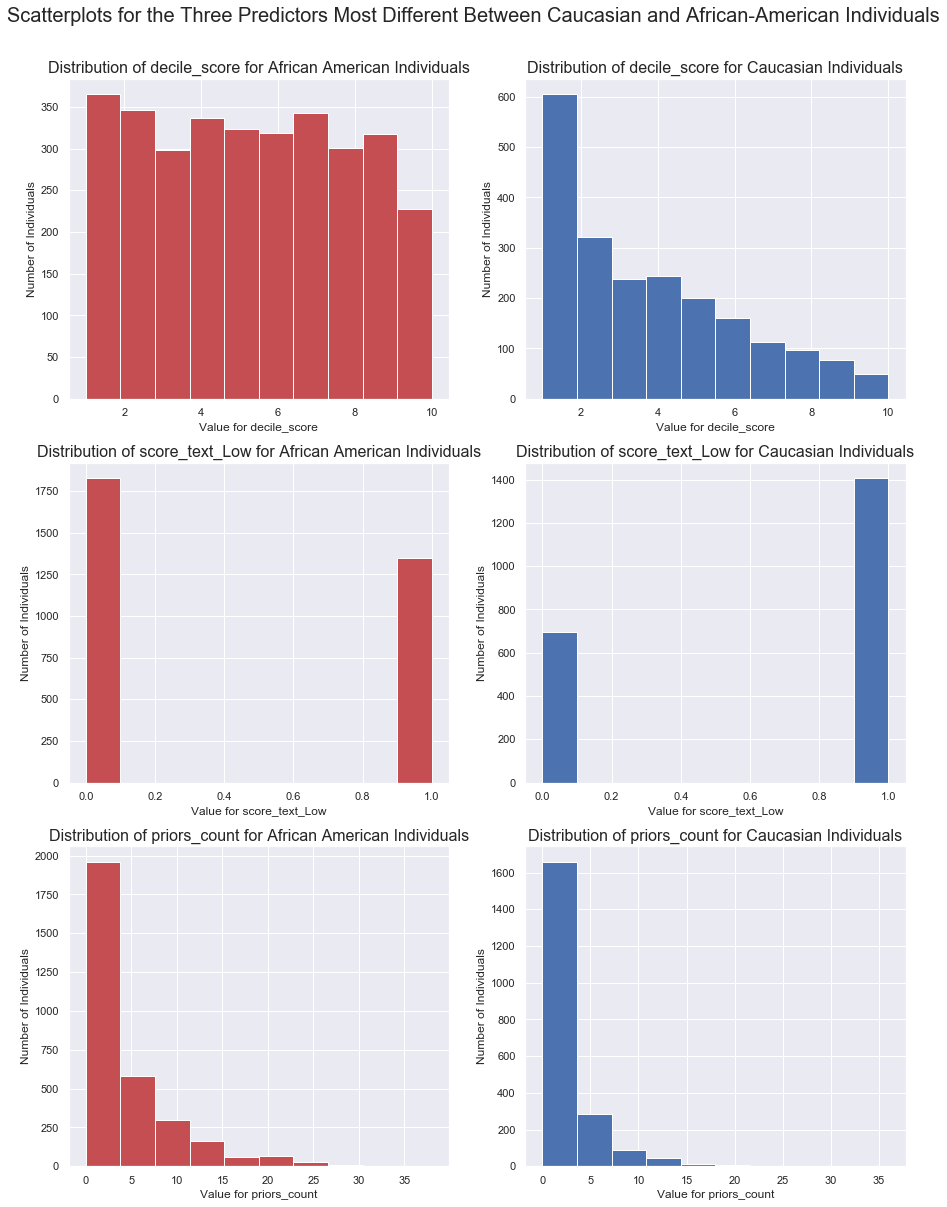

In [36]:
fig, ax = plt.subplots(3, 2, figsize= (15, 20))
fig.suptitle("Scatterplots for the Three Predictors Most Different Between Caucasian and African-American Individuals", fontsize = '20', y = .93)
for i, predictor in enumerate(sortedTScores[:3]):
    ax[i][0].set_title('Distribution of {} for African American Individuals'.format(predictor['predictor']), fontsize = '16')
    ax[i][1].set_title('Distribution of {} for Caucasian Individuals'.format(predictor['predictor']), fontsize = '16')
    ax[i][0].hist(AfrAm[predictor['predictor']], color = 'r')
    ax[i][1].hist(Cauc[predictor['predictor']], color = 'b')
    ax[i][0].set_xlabel('Value for {}'.format(predictor['predictor']))
    ax[i][1].set_xlabel('Value for {}'.format(predictor['predictor']))
    ax[i][0].set_ylabel('Number of Individuals')
    ax[i][1].set_ylabel('Number of Individuals')

We notice that the scatterplot for African American individuals on decile score is much more evenly distributed across all 10 scores. On the other hand, the same plot for Caucasian individuals is strikingly different as it is skewed to the left with much more individuals having low risk scores than the more high risk ones. In the score_text_Low one-hot-encoded variable, we notice that more African-American individuals have 0 for this attribute, meaning they do not have a low risk score, than African-American individuals who do have a low risk score. Yet, for Caucasian individuals, there are much more individuals who do have a low risk score (value of 1) than Caucasian individuals who do not have a low risk score (0). In terms of priors count, there are more African-Americans in the prior crimes count bins of 10, 15, 20, and 25, than there are white individuals. Again, this does not necessarily mean that African-American individuals committed more crimes, it means they have been caught for more crimes than Caucasian individuals. This will be explained in 4.3. 

**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

For the variable of priors count, biased policing could be impacting how many prior crimes each racial group seems to have committed. Empirical studies show that African-American individuals are stopped and incarcerated more than Caucasian individuals, as also mentioned in the ethiCS lecture, which would skew the priors_count to seem that African-Americans have much more priors, ultimately impacting their risk score. As for score_text_Low, this metric is based on the COMPAS algorithm, which can take into account factors like priors_count that can be biased in terms of policing and racial bias in the judiciary system for who is ultimately convicted and the framing of the crime. Similarly, the decile_score is based on factors that can be biased, ultimately impacting the degree of the discrepancy between Caucasian and African-American individuals in the same way as the score_text_Low.

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

## Multiple Logistic Regression Model

In [37]:
# your code here
recidMultiLogistic = LogisticRegression(C = 1000000, solver = 'liblinear').fit(X_train, y_train)
recidMultiLogisticTest = recidMultiLogistic.predict_proba(X_test)[:, 1]

for i in range(len(recidMultiLogisticTest)):
    if recidMultiLogisticTest[i] > .5:
        recidMultiLogisticTest[i] = 1
    else:
        recidMultiLogisticTest[i] = 0

print("The misclassification rate of the logistic model on the test set is {}.".format(1-accuracy_score(recidMultiLogisticTest, y_test)))

The misclassification rate of the logistic model on the test set is 0.31818181818181823.


## k-NN Model

In [38]:
# your code here
k_list = [1, 2, 3, 4, 5, 7, 9, 10, 15, 25, 50]
best_k = 0
best_model = None
best_score = -1

for k in k_list:
    model = KNeighborsClassifier(n_neighbors = k)
    cv_scores = cross_val_score(model, X_train, y_train, cv = 5)
    mean_score = np.mean(cv_scores)
    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_k = k
knnR = best_model.fit(X_train, y_train)

best_test_score = np.mean(knnR.score(X_test, y_test))
print("The best k for our classification model will be {}".format(best_k))
print("The k = {} model has a misclassification rate on the test set of {}".format(best_k, 1-best_test_score))

The best k for our classification model will be 25
The k = 25 model has a misclassification rate on the test set of 0.3304924242424242


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [39]:
# your code here
X_trainNoRace = X_train.drop(columns = 'race_Caucasian')
X_testNoRace = X_test.drop(columns = 'race_Caucasian')
X_trainNoRace.head()

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,c_charge_degree_M,score_text_Low,score_text_Medium,sex_Male
3767,37,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0
6090,24,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
6072,38,16,2,3,0,9,33,0,0,1,1,1,0,0,1,0,30,1,0,0,1
3003,37,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0
5138,22,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1


## Multiple Logistic Regression without Race

### Confusion Matrix for MLR WITH Race

In [40]:
scores2 = []
MLRRace = confusion_matrix(y_test, recidMultiLogisticTest)
print(MLRRace)
print("False positive rates for Multiple Logistic Regression classification with race included: {}".format(MLRRace[0][1]/np.sum(MLRRace[0])))
print("False negative rates for Multiple Logistic Regression classification with race included: {}".format(MLRRace[1][0]/np.sum(MLRRace[1])))
scores2.append([1-accuracy_score(recidMultiLogisticTest, y_test), MLRRace[0][1]/np.sum(MLRRace[0]), MLRRace[1][0]/np.sum(MLRRace[1])])

[[417 146]
 [190 303]]
False positive rates for Multiple Logistic Regression classification with race included: 0.25932504440497334
False negative rates for Multiple Logistic Regression classification with race included: 0.385395537525355


### Misclassification Rate and Confusion Matrix for MLR WITHOUT Race

In [41]:
recidMultiLogisticNR = LogisticRegression(C = 1000000, solver = 'liblinear').fit(X_trainNoRace, y_train)
recidMultiLogisticTestNR = recidMultiLogisticNR.predict_proba(X_testNoRace)[:, 1]

for i in range(len(recidMultiLogisticTestNR)):
    if recidMultiLogisticTestNR[i] > .5:
        recidMultiLogisticTestNR[i] = 1
    else:
        recidMultiLogisticTestNR[i] = 0

print("The misclassification rate of the logistic model on the test set without race is {}.".format(1-accuracy_score(recidMultiLogisticTestNR, y_test)))
MLRNoRace = confusion_matrix(y_test, recidMultiLogisticTestNR)
print(MLRNoRace)
print("False positive rates for Multiple Logistic Regression classification without race included: {}".format(MLRNoRace[0][1]/np.sum(MLRNoRace[0])))
print("False negative rates for Multiple Logistic Regression classification without race included: {}".format(MLRNoRace[1][0]/np.sum(MLRNoRace[1])))
scores2.append([1-accuracy_score(recidMultiLogisticTestNR, y_test), MLRNoRace[0][1]/np.sum(MLRNoRace[0]), MLRNoRace[1][0]/np.sum(MLRNoRace[1])])

The misclassification rate of the logistic model on the test set without race is 0.31818181818181823.
[[417 146]
 [190 303]]
False positive rates for Multiple Logistic Regression classification without race included: 0.25932504440497334
False negative rates for Multiple Logistic Regression classification without race included: 0.385395537525355


## k-NN Model without Race

### Confusion Matrix for k-NN WITH Race

In [42]:
knnPredictTestWR = knnR.predict(X_test)
confusionKNN = confusion_matrix(y_test, knnPredictTestWR)
print(confusionKNN)
print("False positive rates for k-NN classification (k = 25) without race included: {}".format(confusionKNN[0][1]/np.sum(confusionKNN[0])))
print("False negative rates for k-NN classification (k = 25) without race included: {}".format(confusionKNN[1][0]/np.sum(confusionKNN[1])))
scores2.append([1-best_test_score, confusionKNN[0][1]/np.sum(confusionKNN[0]), confusionKNN[1][0]/np.sum(confusionKNN[1])])

[[404 159]
 [190 303]]
False positive rates for k-NN classification (k = 25) without race included: 0.2824156305506217
False negative rates for k-NN classification (k = 25) without race included: 0.385395537525355


### Confusion Matrix for k-NN WITHOUT Race

In [43]:
knnNR = best_model.fit(X_trainNoRace, y_train)

best_test_scoreWR = np.mean(knnNR.score(X_testNoRace, y_test))
print("Misclassification rate for k-NN (k = 25) model without race included: {}".format(1-best_test_scoreWR))
knnPredictTestNR = knnNR.predict(X_testNoRace)
confusionKNN_NR = confusion_matrix(y_test, knnPredictTestNR)
print(confusionKNN_NR)
print("False positive rates for k-NN classification (k = 25) without race included: {}".format(confusionKNN_NR[0][1]/np.sum(confusionKNN_NR[0])))
print("False negative rates for k-NN classification (k = 25) without race included: {}".format(confusionKNN_NR[1][0]/np.sum(confusionKNN_NR[1])))
scores2.append([1-best_test_scoreWR, confusionKNN_NR[0][1]/np.sum(confusionKNN_NR[0]), confusionKNN_NR[1][0]/np.sum(confusionKNN_NR[1])])

Misclassification rate for k-NN (k = 25) model without race included: 0.3314393939393939
[[403 160]
 [190 303]]
False positive rates for k-NN classification (k = 25) without race included: 0.2841918294849023
False negative rates for k-NN classification (k = 25) without race included: 0.385395537525355


In [44]:
modelsRace = ['Multiple Logistic Regression with Race', 'Multiple Logistic Regression without Race', 'kNN (k = 25) with Race', 'kNN (k = 25) without Race']
df_Race = pd.DataFrame(scores2, index = modelsRace, columns = ['Misclassification Rate', 'False Positive Rate', 'False Negative Rate'])
df_Race

,Misclassification Rate,False Positive Rate,False Negative Rate
Multiple Logistic Regression with Race,0.318182,0.259325,0.385396
Multiple Logistic Regression without Race,0.318182,0.259325,0.385396
kNN (k = 25) with Race,0.330492,0.282416,0.385396
kNN (k = 25) without Race,0.331439,0.284192,0.385396


**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

Our exploration and modeling of the data shows us that with and without race being included in the model, our misclassification rate and false positive/negative rates are still amost exactly the same. One might be tempted to conclude from these results that the model is unbiased in predicting one's risk independent of their race, but we have to take a closer look. In question 4.2, we showed through EDA that black individuals have a much higher average prior criminal counts as well as a much higher decile score in general. These two predictors can be based on data that is biased, even if the tool itself claims to be unbiased. The fact that the misclassification and false positive/negative rates stayed almost exactly the same with and without race included shows that all of the other predictors are still biased themselves. There are socioeconomic factors at play that disadvantage African-American individuals in terms of how strictly they are policed, how harsh their sentences are, and how likely their crimes are to be reported. This systemic bias means that even if a model does not explicitly include a variable such as race, the model is inherently biased because of the predictors upon which it relies, so its predictions of future crime, or recidivism, will be racially biased.

---